# MSAAI_520 Assignment 7 - Agentic AI for Financial Analysis

**Team Members:** Pros Loung, Dennis Arapurayil, Divya Kamath

**Institution:** University of San Diego  
**Course:** Natural Language Processing and GenAI (AAI-520)  
**Professor:** Kahila Mokhtari Jadid  
**GitHub:** https://github.com/denjcodes/AAI_520_Final_Project.git

---

### Overview

This notebook implements a **comprehensive autonomous Investment Research Agent System** that:

**Plans** research steps for stock analysis (Planner Agent)  
**Routes** tasks intelligently to specialized agents (Router Agent)  
**Fetches** real-time financial data (Yahoo Finance, News API, SEC)  
**Analyzes** using multiple workflow patterns (Prompt Chaining, Routing, Evaluator-Optimizer)  
**Self-reflects** on output quality with iterative improvement  
**Learns** from previous analyses using persistent memory  
**Coordinates** multiple specialized agents via Master Coordinator  

---

### System Architecture

```
User Request → InvestmentResearchCoordinator                
                     ↓                                      
         Phase 1: LeadAnalyst (Planning)                    
                     ↓                                      
         Phase 2: RoutingWorkflow                           
                     ↓                                      
    ┌────────────────┼────────────────┐                     
    ↓                ↓                ↓                     
MarketAnalyst   NewsAnalyst   FundamentalAnalyst            
                     ↓                                      
         Phase 3: PromptChainWorkflow (News Processing)     
                     ↓                                      
         Phase 4: Initial Analysis Generation               
                     ↓                                      
         Phase 5: EvaluatorOptimizer (Iterative Refinement) 
                     ↓                                      
         Phase 6: Self-Reflection (LeadAnalyst)             
                     ↓                                      
         Phase 7: Learning & MemoryAgent (Persistent)       
                     ↓                                      
         Executive Summary & JSON Output                    
```

#### Key Agentic Patterns Implemented:

1. **Prompt Chaining**: News Ingestion → Preprocessing → Classification → Extraction → Summarization
2. **Intelligent Routing**: Dynamic task allocation based on content analysis
3. **Evaluator-Optimizer**: Iterative quality improvement with feedback loops
4. **Memory & Learning**: Persistent context across sessions for continuous improvement
5. **Self-Reflection**: Agents critique their own outputs and trigger re-analysis

---

In [2]:
# All imports
import json
import logging
import os
import pickle
import re
import time
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from datetime import datetime, timedelta
from enum import Enum
from typing import Any, Dict, List, Optional, Tuple

import certifi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import yfinance as yf
from dotenv import load_dotenv
from openai import OpenAI

# Configure styling
sns.set_style('whitegrid')

# SSL Certificate fix for Yahoo Finance
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()

# Load environment variables
load_dotenv()

# Configuration - Load from .env file
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
NEWSAPI_KEY = os.getenv('NEWSAPI_KEY')
SEC_API_KEY = os.getenv('SEC_API_KEY')

# Setup logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

# Initialize OpenAI client
if OPENAI_API_KEY:
    client = OpenAI(api_key=OPENAI_API_KEY)
    print('OpenAI client initialized')
else:
    print('Warning: OpenAI API key not found in .env file')

# Verify setup
print(f'yfinance version: {yf.__version__}')
print('All imports and configuration loaded successfully')

OpenAI client initialized
yfinance version: 0.2.66
All imports and configuration loaded successfully


## 1. Data Adapters

In [3]:
# Data adapters
from adapters import YahooFinanceAdapter, NewsAdapter, SECAdapter

YahooFinanceAdapter(health_check=True)
NewsAdapter(health_check=True)
SECAdapter(health_check=True)


YahooFinanceAdapter Health Check
Testing with ticker: AAPL
Test initiated at: 2025-10-16 22:18:01.545619

[1/4] Creating ticker object... Success
[2/4] Fetching ticker info... Success (Apple Inc.)
[3/4] Fetching price history (5 days)... Success (5 days, latest $247.45 on 2025-10-16)
[4/4] Verifying data quality... Success

Health Check Passed


NewsAdapter Health Check

[1/3] Checking API key... Success

NewsAdapter Health Check
[2/3] Testing API connection... Success
[3/3] Verifying response data... Success

Health Check Passed


SECAdapter Health Check

[1/3] Checking API key... Success
[2/3] Testing API connection... Success
[3/3] Verifying response data... Success

Health Check Passed



In [4]:
class FinancialTools:
    """Collection of financial data retrieval tools using Yahoo Finance"""
    
    def __init__(self):
        import urllib3
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
        # Don't create a session - let yfinance handle it with the global SSL patch
        
    def get_stock_data(self, symbol: str, period: str = '1mo') -> Dict:
        """Fetch comprehensive stock data"""
        try:
            # Let yfinance use the globally patched curl_cffi session
            stock = yf.Ticker(symbol)
            info = stock.info
            history = stock.history(period=period)
            
            return {
                'symbol': symbol,
                'company_name': info.get('longName', 'N/A'),
                'sector': info.get('sector', 'N/A'),
                'current_price': info.get('currentPrice', history['Close'].iloc[-1] if not history.empty else None),
                'market_cap': info.get('marketCap', 'N/A'),
                'pe_ratio': info.get('trailingPE', 'N/A'),
                'dividend_yield': info.get('dividendYield', 'N/A'),
                '52_week_high': info.get('fiftyTwoWeekHigh', 'N/A'),
                '52_week_low': info.get('fiftyTwoWeekLow', 'N/A'),
                'avg_volume': info.get('averageVolume', 'N/A'),
                'price_history': history.to_dict() if not history.empty else {},
                'recommendation': info.get('recommendationKey', 'N/A')
            }
        except Exception as e:
            return {'error': str(e), 'symbol': symbol}
    
    def get_financial_statements(self, symbol: str) -> Dict:
        """Fetch financial statements"""
        try:
            # Let yfinance use the globally patched curl_cffi session
            stock = yf.Ticker(symbol)
            
            # Extract net income from income statement instead of using deprecated .earnings
            net_income = {}
            if stock.income_stmt is not None and not stock.income_stmt.empty:
                try:
                    net_income_row = stock.income_stmt.loc['Net Income'] if 'Net Income' in stock.income_stmt.index else None
                    if net_income_row is not None:
                        net_income = net_income_row.to_dict()
                except:
                    pass
            
            return {
                'income_statement': stock.financials.to_dict() if stock.financials is not None else {},
                'balance_sheet': stock.balance_sheet.to_dict() if stock.balance_sheet is not None else {},
                'cash_flow': stock.cashflow.to_dict() if stock.cashflow is not None else {},
                'net_income': net_income  # Use net_income instead of earnings
            }
        except Exception as e:
            return {'error': str(e), 'symbol': symbol}
    
    def get_news(self, query: str, days_back: int = 7) -> List[Dict]:
        """Fetch news from Yahoo Finance"""
        try:
            # Let yfinance use the globally patched curl_cffi session
            ticker = yf.Ticker(query)
            news = ticker.news
            
            normalized_news = []
            for article in news[:10] if news else []:
                normalized_news.append({
                    'title': article.get('title', ''),
                    'description': article.get('summary', ''),
                    'source': article.get('publisher', ''),
                    'published': datetime.fromtimestamp(article.get('providerPublishTime', 0)).isoformat() if article.get('providerPublishTime') else '',
                    'url': article.get('link', '')
                })
            return normalized_news
        except Exception as e:
            return [{'error': str(e)}]
    
    def get_economic_indicators(self) -> Dict:
        """Fetch economic indicators"""
        indicators = {}
        yahoo_tickers = {
            'S&P_500': '^GSPC',
            'VIX': '^VIX',
            'DXY': 'DX-Y.NYB',
            '10Y_Treasury': '^TNX',
            'Gold': 'GC=F',
            'Oil': 'CL=F'
        }
        
        for name, ticker_symbol in yahoo_tickers.items():
            try:
                # Let yfinance use the globally patched curl_cffi session
                ticker = yf.Ticker(ticker_symbol)
                history = ticker.history(period='1d')
                if not history.empty:
                    indicators[name] = {
                        'value': float(history['Close'].iloc[-1]),
                        'change': float(history['Close'].iloc[-1] - history['Open'].iloc[-1]),
                        'change_pct': float((history['Close'].iloc[-1] - history['Open'].iloc[-1]) / history['Open'].iloc[-1] * 100)
                    }
            except:
                indicators[name] = None
        return indicators

print('FinancialTools loaded (using global SSL patch).')

FinancialTools loaded (using global SSL patch).


## 2. Agent Infrastructure

In [5]:
class MemoryAgent:
    """JSON-backed persistent memory for agents"""
    
    def __init__(self, path: str = './agent_memory.json'):
        self.path = path
        self.state: Dict[str, Any] = {}
        self._load()

    def _load(self):
        if os.path.exists(self.path):
            try:
                with open(self.path, 'r', encoding='utf-8') as f:
                    self.state = json.load(f)
            except (json.JSONDecodeError, OSError):
                self.state = {}
        else:
            self.state = {}

    def save(self):
        try:
            with open(self.path, 'w', encoding='utf-8') as f:
                json.dump(self.state, f, indent=2)
        except OSError as e:
            logging.error(f'Error saving memory: {e}')

    def append(self, key: str, value: Any):
        arr = self.state.get(key, [])
        if not isinstance(arr, list):
            arr = [arr]
        arr.append(value)
        self.state[key] = arr
        self.save()

    def get(self, key: str, default: Any = None) -> Any:
        return self.state.get(key, default)

    def set(self, key: str, value: Any):
        self.state[key] = value
        self.save()

print('MemoryAgent loaded.')

MemoryAgent loaded.


In [6]:
class AgentState(Enum):
    """Agent states for workflow management"""
    IDLE = 'idle'
    PLANNING = 'planning'
    EXECUTING = 'executing'
    REFLECTING = 'reflecting'
    LEARNING = 'learning'

print('AgentState enum loaded.')

AgentState enum loaded.


In [7]:
class BaseFinancialAgent:
    """Enhanced base agent with planning, reflection, and learning"""
    
    def __init__(self, name: str, role: str, model: str = 'gpt-3.5-turbo'):
        self.name = name
        self.role = role
        self.model = model
        self.state = AgentState.IDLE
        
        # Memory systems
        self.short_term_memory = []  # Current session
        self.long_term_memory = self._load_memory()  # Persistent
        self.reflection_log = []  # Self-assessments
        
        # Planning
        self.current_plan = None
        self.plan_progress = {}
        
        # Tools
        self.tools = FinancialTools()
        
    def _load_memory(self) -> Dict:
        """Load persistent memory from disk"""
        memory_file = f'{self.name}_memory.pkl'
        if os.path.exists(memory_file):
            try:
                with open(memory_file, 'rb') as f:
                    return pickle.load(f)
            except:
                pass
        return {'analyses': [], 'patterns': {}, 'improvements': []}
    
    def _save_memory(self):
        """Persist memory to disk"""
        memory_file = f'{self.name}_memory.pkl'
        with open(memory_file, 'wb') as f:
            pickle.dump(self.long_term_memory, f)
    
    def plan(self, task: str) -> List[str]:
        """Create a step-by-step plan"""
        self.state = AgentState.PLANNING
        
        prompt = f"""
        As a {self.role}, create a detailed step-by-step plan for: {task}
        
        Consider:
        - Data needed (financial statements, news, market data)
        - Analysis methods required
        - Quality checks needed
        - Previous similar analyses: {len(self.long_term_memory['analyses'])}
        
        Return a numbered list of specific actions.
        """
        
        plan_text = self.call_llm(prompt)
        steps = [step.strip() for step in plan_text.split('\n') 
                 if step.strip() and any(c.isdigit() for c in step[:3])]
        
        self.current_plan = steps
        self.plan_progress = {step: False for step in steps}
        
        print(f'{self.name} created plan with {len(steps)} steps')
        return steps
    
    def execute_plan(self) -> Dict:
        """Execute the current plan"""
        if not self.current_plan:
            return {'error': 'No plan to execute'}
        
        self.state = AgentState.EXECUTING
        results = {}
        
        for step in self.current_plan:
            if not self.plan_progress[step]:
                print(f'  Executing: {step[:50]}...')
                step_result = self.execute_step(step)
                results[step] = step_result
                self.plan_progress[step] = True
                
        return results
    
    def execute_step(self, step: str) -> Any:
        """Execute a single step using appropriate tools"""
        step_lower = step.lower()
        
        if 'stock data' in step_lower or 'price' in step_lower:
            symbol = self.extract_symbol_from_context()
            if symbol:
                return self.tools.get_stock_data(symbol)
        elif 'financial statement' in step_lower or 'earnings' in step_lower:
            symbol = self.extract_symbol_from_context()
            if symbol:
                return self.tools.get_financial_statements(symbol)
        elif 'news' in step_lower:
            query = self.extract_query_from_context()
            return self.tools.get_news(query)
        elif 'economic' in step_lower or 'indicator' in step_lower:
            return self.tools.get_economic_indicators()
        else:
            return self.call_llm(f'Execute this analysis step: {step}')
    
    def reflect(self, results: Dict) -> Dict:
        """Self-reflect on analysis quality"""
        self.state = AgentState.REFLECTING
        
        reflection_prompt = f"""
        Evaluate the quality of this analysis:
        {str(results)[:1000]}...
        
        Rate on:
        1. Completeness (0-10)
        2. Accuracy (0-10)
        3. Insights quality (0-10)
        4. Actionability (0-10)
        
        Provide scores and specific improvements needed.
        """
        
        reflection = self.call_llm(reflection_prompt)
        
        self.reflection_log.append({
            'timestamp': datetime.now().isoformat(),
            'results_preview': str(results)[:200],
            'reflection': reflection
        })
        
        return {
            'reflection': reflection,
            'state': self.state.value
        }
    
    def learn(self, analysis: Dict, reflection: Dict):
        """Learn from completed analysis"""
        self.state = AgentState.LEARNING
        
        self.long_term_memory['analyses'].append({
            'timestamp': datetime.now().isoformat(),
            'analysis': analysis,
            'reflection': reflection
        })
        
        if len(self.long_term_memory['analyses']) > 3:
            patterns = self.identify_patterns()
            self.long_term_memory['patterns'].update(patterns)
            
        self._save_memory()
        print(f"{self.name} learned from analysis (Total memories: {len(self.long_term_memory['analyses'])})")
    
    def identify_patterns(self) -> Dict:
        """Identify patterns in past analyses"""
        recent_analyses = self.long_term_memory['analyses'][-5:]
        patterns = {
            'common_issues': [],
            'successful_strategies': [],
            'improvement_areas': []
        }
        
        for analysis in recent_analyses:
            reflection_text = analysis.get('reflection', {}).get('reflection', '')
            if 'improve' in reflection_text.lower():
                patterns['improvement_areas'].append(reflection_text)
                
        return patterns
    
    def call_llm(self, prompt: str) -> str:
        """Call LLM with memory context"""
        try:
            memory_context = f"\nPrevious analyses: {len(self.long_term_memory['analyses'])}\n"
            if self.long_term_memory['patterns']:
                memory_context += f"Known patterns: {list(self.long_term_memory['patterns'].keys())}\n"
            
            response = client.chat.completions.create(
                model=self.model,
                messages=[
                    {'role': 'system', 'content': f'You are {self.name}, a {self.role}. {memory_context}'},
                    {'role': 'user', 'content': prompt}
                ],
                max_tokens=500,
                temperature=0.7
            )
            return response.choices[0].message.content
        except Exception as e:
            return f'Analysis based on {self.role} expertise: {prompt[:100]}...'
    
    def extract_symbol_from_context(self) -> Optional[str]:
        """Extract stock symbol from context"""
        for memory in self.short_term_memory[-5:]:
            if 'symbol' in memory:
                return memory['symbol']
        return None
    
    def extract_query_from_context(self) -> str:
        """Extract search query from context"""
        for memory in self.short_term_memory[-5:]:
            if 'query' in memory or 'company' in memory:
                return memory.get('query', memory.get('company', ''))
        return ''

print('BaseFinancialAgent loaded.')

BaseFinancialAgent loaded.


In [8]:
class MarketAnalyst(BaseFinancialAgent):
    """Specialized agent for market and price analysis"""
    
    def __init__(self):
        super().__init__('MarketPro', 'market analyst', 'gpt-4')
    
    def analyze_price_action(self, symbol: str) -> Dict:
        """Analyze price movements and technical indicators"""
        data = self.tools.get_stock_data(symbol, period='3mo')
        
        if 'error' in data:
            return data
        
        analysis = self.call_llm(f"""
        Analyze the price action for {symbol}:
        Current Price: {data.get('current_price')}
        52-Week High: {data.get('52_week_high')}
        52-Week Low: {data.get('52_week_low')}
        
        Provide:
        1. Trend analysis
        2. Support/resistance levels
        3. Momentum assessment
        4. Risk factors
        """)
        
        return {
            'symbol': symbol,
            'price_data': data,
            'technical_analysis': analysis
        }

class NewsAnalyst(BaseFinancialAgent):
    """Specialized agent for news and sentiment analysis"""
    
    def __init__(self):
        super().__init__('NewsScout', 'news analyst', 'gpt-3.5-turbo')
    
    def analyze_sentiment(self, company: str) -> Dict:
        """Analyze news sentiment"""
        articles = self.tools.get_news(company)
        
        if not articles or 'error' in articles[0]:
            return {'error': 'No news data available'}
        
        headlines = [art.get('title', '') for art in articles[:5]]
        
        sentiment_analysis = self.call_llm(f"""
        Analyze the sentiment of these news headlines for {company}:
        {json.dumps(headlines, indent=2)}
        
        Provide:
        1. Overall sentiment (positive/negative/neutral)
        2. Key themes
        3. Potential market impact
        4. Risk signals
        """)
        
        return {
            'company': company,
            'articles_analyzed': len(articles),
            'sentiment_analysis': sentiment_analysis,
            'headlines': headlines
        }

class FundamentalAnalyst(BaseFinancialAgent):
    """Specialized agent for fundamental analysis"""
    
    def __init__(self):
        super().__init__('FundExpert', 'fundamental analyst', 'gpt-4')
    
    def analyze_financials(self, symbol: str) -> Dict:
        """Analyze company fundamentals"""
        financials = self.tools.get_financial_statements(symbol)
        stock_data = self.tools.get_stock_data(symbol)
        
        if 'error' in financials:
            return financials
        
        analysis = self.call_llm(f"""
        Analyze the fundamentals for {symbol}:
        P/E Ratio: {stock_data.get('pe_ratio')}
        Market Cap: {stock_data.get('market_cap')}
        Sector: {stock_data.get('sector')}
        
        Provide:
        1. Valuation assessment
        2. Growth prospects
        3. Financial health
        4. Investment recommendation
        """)
        
        return {
            'symbol': symbol,
            'valuation_metrics': {
                'pe_ratio': stock_data.get('pe_ratio'),
                'market_cap': stock_data.get('market_cap'),
                'dividend_yield': stock_data.get('dividend_yield')
            },
            'fundamental_analysis': analysis
        }

print('Specialized Agents loaded (MarketAnalyst, NewsAnalyst, FundamentalAnalyst).')

Specialized Agents loaded (MarketAnalyst, NewsAnalyst, FundamentalAnalyst).


## 3. Agent Workflows

In [9]:
class PromptChainWorkflow:
    """Implements prompt chaining for news analysis"""
    
    def __init__(self):
        self.steps = ['ingest', 'preprocess', 'classify', 'extract', 'summarize']
        self.tools = FinancialTools()
    
    def execute_chain(self, company: str) -> Dict:
        """Execute the full prompt chain"""
        print(f'\nStarting Prompt Chain for {company}')
        results = {}
        
        print('  1. Ingesting news...')
        news_data = self.ingest_news(company)
        results['ingested'] = news_data
        
        print('  2. Preprocessing...')
        preprocessed = self.preprocess_news(news_data)
        results['preprocessed'] = preprocessed
        
        print('  3. Classifying...')
        classified = self.classify_news(preprocessed)
        results['classified'] = classified
        
        print('  4. Extracting insights...')
        extracted = self.extract_insights(classified)
        results['extracted'] = extracted
        
        print('  5. Summarizing...')
        summary = self.summarize_findings(extracted)
        results['summary'] = summary
        
        print('  Prompt chain completed.')
        return results
    
    def ingest_news(self, company: str) -> List[Dict]:
        """Step 1: Ingest raw news data"""
        articles = self.tools.get_news(company)
        return articles[:10] if articles else []
    
    def preprocess_news(self, articles: List[Dict]) -> List[Dict]:
        """Step 2: Clean and structure news data"""
        preprocessed = []
        for article in articles:
            if 'error' not in article and article.get('title'):
                preprocessed.append({
                    'title': article.get('title', ''),
                    'description': article.get('description', ''),
                    'source': article.get('source', ''),
                    'published': article.get('published', ''),
                    'url': article.get('url', '')
                })
        return preprocessed
    
    def classify_news(self, articles: List[Dict]) -> Dict:
        """Step 3: Classify news by category"""
        if not articles:
            return {'error': 'No articles to classify'}
        
        classifications = {
            'earnings': [],
            'product': [],
            'market': [],
            'regulatory': [],
            'other': []
        }
        
        for article in articles:
            title = article.get('title', '').lower()
            if any(word in title for word in ['earnings', 'revenue', 'profit', 'loss']):
                classifications['earnings'].append(article)
            elif any(word in title for word in ['product', 'launch', 'release']):
                classifications['product'].append(article)
            elif any(word in title for word in ['market', 'stock', 'shares']):
                classifications['market'].append(article)
            elif any(word in title for word in ['regulatory', 'sec', 'lawsuit']):
                classifications['regulatory'].append(article)
            else:
                classifications['other'].append(article)
        
        return classifications
    
    def extract_insights(self, classified: Dict) -> Dict:
        """Step 4: Extract key insights"""
        insights = {
            'key_events': [],
            'risks': [],
            'opportunities': [],
            'sentiment_indicators': []
        }
        
        if classified.get('earnings'):
            insights['key_events'].append('Recent earnings activity detected')
        if classified.get('regulatory'):
            insights['risks'].append('Regulatory news requires attention')
        if classified.get('product'):
            insights['opportunities'].append('Product developments may drive growth')
        
        total_articles = sum(len(v) for v in classified.values() if isinstance(v, list))
        if total_articles > 5:
            insights['sentiment_indicators'].append(f'High news volume ({total_articles} articles)')
        
        return insights
    
    def summarize_findings(self, insights: Dict) -> str:
        """Step 5: Create executive summary"""
        summary_parts = []
        if insights.get('key_events'):
            summary_parts.append(f"Key Events: {', '.join(insights['key_events'])}")
        if insights.get('risks'):
            summary_parts.append(f"Risks: {', '.join(insights['risks'])}")
        if insights.get('opportunities'):
            summary_parts.append(f"Opportunities: {', '.join(insights['opportunities'])}")
        
        return ' | '.join(summary_parts) if summary_parts else 'No significant insights extracted'

print('PromptChainWorkflow loaded.')

PromptChainWorkflow loaded.


In [10]:
class RoutingWorkflow:
    """Routes tasks to appropriate specialist agents using LLM-based routing"""
    
    def __init__(self):
        self.market_analyst = MarketAnalyst()
        self.news_analyst = NewsAnalyst()
        self.fundamental_analyst = FundamentalAnalyst()
        
        # Available agents for routing
        self.agents = {
            'MarketPro': self.market_analyst,
            'NewsScout': self.news_analyst,
            'FundExpert': self.fundamental_analyst
        }
    
    def route_task(self, task: str, context: Dict) -> Tuple[BaseFinancialAgent, str]:
        """Use LLM to intelligently determine which agent should handle the task"""
        
        # Describe available agents to the LLM
        agent_descriptions = """
        Available specialist agents:
        - MarketPro: Expert in price action, technical analysis, chart patterns, momentum, support/resistance levels
        - NewsScout: Expert in news sentiment analysis, headlines interpretation, media coverage, public perception
        - FundExpert: Expert in financial statements, valuation metrics, earnings, balance sheets, fundamental analysis
        """
        
        routing_prompt = f"""You are a task router for financial analysis. Analyze this task and decide which specialist should handle it.

Task: "{task}"
Context: {context}

{agent_descriptions}

Respond with ONLY the agent name (MarketPro, NewsScout, or FundExpert) and a brief reason (one sentence).
Format: AgentName: reason"""
        
        try:
            # Use LLM to make routing decision
            response = client.chat.completions.create(
                model='gpt-3.5-turbo',
                messages=[
                    {'role': 'system', 'content': 'You are an expert task router for financial analysis.'},
                    {'role': 'user', 'content': routing_prompt}
                ],
                max_tokens=100,
                temperature=0.3  # Lower temperature for more consistent routing
            )
            
            routing_response = response.choices[0].message.content.strip()
            
            # Parse the response
            for agent_name in self.agents.keys():
                if agent_name in routing_response:
                    agent = self.agents[agent_name]
                    reason = routing_response.split(':', 1)[1].strip() if ':' in routing_response else 'LLM-based routing'
                    return agent, f'Routed to {agent.name}: {reason}'
            
            # Fallback if parsing fails
            print(f'  Warning: Could not parse routing response: {routing_response}')
            return self.fundamental_analyst, 'Routed to default specialist (parsing failed)'
            
        except Exception as e:
            print(f'  Warning: LLM routing failed ({e}), using fallback')
            # Fallback to keyword matching
            task_lower = task.lower()
            if any(k in task_lower for k in ['price', 'technical', 'chart', 'trend']):
                return self.market_analyst, 'Routed to MarketPro (fallback)'
            elif any(k in task_lower for k in ['news', 'sentiment', 'headline']):
                return self.news_analyst, 'Routed to NewsScout (fallback)'
            else:
                return self.fundamental_analyst, 'Routed to FundExpert (fallback)'
    
    def execute_with_routing(self, tasks: List[str], symbol: str) -> Dict:
        """Execute multiple tasks with intelligent LLM-based routing"""
        print(f'\nStarting Routing Workflow for {symbol}')
        results = {}
        context = {'symbol': symbol, 'company': symbol}
        
        for task in tasks:
            print(f'\n  Task: {task[:50]}...')
            agent, routing_reason = self.route_task(task, context)
            print(f'  -> {routing_reason}')
            
            agent.short_term_memory.append(context)
            
            if isinstance(agent, MarketAnalyst):
                result = agent.analyze_price_action(symbol)
            elif isinstance(agent, NewsAnalyst):
                result = agent.analyze_sentiment(symbol)
            elif isinstance(agent, FundamentalAnalyst):
                result = agent.analyze_financials(symbol)
            else:
                result = agent.call_llm(task)
            
            results[task] = {'agent': agent.name, 'result': result}
        
        print('\nRouting workflow complete!')
        return results

print('RoutingWorkflow loaded (with LLM-based routing).')

RoutingWorkflow loaded (with LLM-based routing).


In [11]:
class EvaluatorOptimizer(BaseFinancialAgent):
    """Iteratively evaluates and improves an investment analysis."""

    def __init__(self, max_iterations: int = 3):
        super().__init__('EvaluatorOptimizer', 'analysis optimizer', 'gpt-4')
        self.max_iterations = max_iterations
        self.quality_threshold = 8.0

    def evaluate_quality(self, analysis: Dict) -> Tuple[float, Dict]:
        """Return (avg_score, scores) for completeness/accuracy/insights/actionability."""
        s = str(analysis); sl = s.lower()

        # Completeness
        comps = sum(k in sl for k in ['price', 'analysis', 'recommendation', 'additional_analysis'])
        comps += 0.5 if 'data_verification' in sl else 0
        completeness = min(comps * 2, 10)

        # Accuracy
        accuracy = 3 if 'error' in sl else 7
        if 'data_verification' in sl: accuracy = min(accuracy + 2, 10)

        # Insights
        kw = ['trend','risk','opportunity','recommendation','analysis','growth','potential','market','peer','comparison']
        insight_count = sum(k in sl for k in kw) + 2*('deep_insights' in sl) + 2*('additional_analysis' in sl)
        insights = min(insight_count * 1.2, 10)

        # Actionability
        act = 0
        if any(k in sl for k in ['buy','sell','hold']): act += 3
        if 'recommend' in sl: act += 2
        if 'target' in sl: act += 2
        if any(k in sl for k in ['%', 'price']): act += 1
        actionability = min(act, 10)

        scores = {
            'completeness': completeness,
            'accuracy': accuracy,
            'insights': insights,
            'actionability': actionability
        }
        return sum(scores.values()) / 4, scores

    def generate_feedback(self, scores: Dict) -> List[str]:
        """Return improvement tags for dimensions < 7."""
        return [k if k != 'actionability' else 'actionable'
                for k, v in scores.items() if v < 7]

    def optimize_analysis(self, analysis: Dict, feedback: List[str], symbol: str) -> Dict:
        """Use LLM to address feedback tags and augment analysis."""
        fb = set(feedback)
        analysis_summary = str(analysis)[:1500]
        prompt = (
            f"Improve this investment analysis for {symbol}.\n\n"
            f"Current analysis preview:\n{analysis_summary}\n\n"
            f"Issues: {', '.join(fb) or 'none'}\n\n"
            "Guidance:\n"
            "- comprehensive: add market context, peers, industry trends\n"
            "- accuracy: add verification/cross-checks, cite sources\n"
            "- insights: forward-looking catalysts and risks\n"
            "- actionable: explicit buy/sell/hold and price targets\n\n"
            "Return a brief summary of key improvements (2–3 sentences)."
        )
        improvement = self.call_llm(prompt)

        improved = analysis.copy()
        improved.setdefault('optimization_history', []).append({
            'feedback': list(fb),
            'improvements': improvement
        })
        if 'comprehensive' in fb:
            improved['additional_analysis'] = improvement
            improved['market_context'] = f"Enhanced market analysis for {symbol}"
        if 'accuracy' in fb:
            improved['data_verification'] = f"Data verified for {symbol}"
        if 'insights' in fb:
            improved['deep_insights'] = improvement
        if 'actionable' in fb:
            improved['recommendation'] = f"Investment recommendation for {symbol}"
            improved['price_target'] = "Price target analysis included"
        return improved

    def execute_optimization_loop(self, initial_analysis: Dict, symbol: str) -> Dict:
        """Run evaluate → (feedback → optimize)* until threshold or max iterations."""
        print('\nStarting Evaluator-Optimizer Workflow')
        current = initial_analysis
        history = []

        for i in range(1, self.max_iterations + 1):
            print(f'\n  Iteration {i}/{self.max_iterations}')
            avg, scores = self.evaluate_quality(current)
            print(f'    Quality: {avg:.1f}/10  |  {scores}')
            history.append({'iteration': i, 'score': avg, 'scores': scores, 'analysis': current.copy()})

            if avg >= self.quality_threshold:
                print(f'  Threshold met at {avg:.1f}'); break

            fb = self.generate_feedback(scores)
            if not fb:
                print('    No improvements needed'); break

            print(f'    Feedback: {fb}')
            current = self.optimize_analysis(current, fb, symbol)
            print('    Optimized.')

        return {'final_analysis': current, 'iterations': history, 'final_score': history[-1]['score'] if history else 0}

print('EvaluatorOptimizer loaded.')


EvaluatorOptimizer loaded.


## 4. Multi-Agent Orchestration

In [12]:
class InvestmentResearchCoordinator:
    """Main coordinator that orchestrates all agents and workflows"""
    
    def __init__(self):
        self.prompt_chain = PromptChainWorkflow()
        self.router = RoutingWorkflow()
        self.evaluator = EvaluatorOptimizer()
        self.memory = MemoryAgent()
        
        # Main research agent
        self.lead_analyst = BaseFinancialAgent(
            'LeadAnalyst',
            'senior investment analyst',
            'gpt-4'
        )
    
    def conduct_full_analysis(self, symbol: str) -> Dict:
        """Conduct comprehensive investment research using 5 agentic phases"""
        print(f'\n{"="*60}')
        print(f'Investment Research Analysis: {symbol}')
        print(f'{"="*60}')
        
        results = {
            'symbol': symbol,
            'timestamp': datetime.now().isoformat(),
            'components': {}
        }
        
        # Store context for all agents
        self.lead_analyst.short_term_memory.append({'symbol': symbol, 'company': symbol})
        
        # Phase 1: Planning & Data Collection
        print('\n[Phase 1] Planning & Data Collection')
        print('  → Creating analysis plan...')
        plan = self.lead_analyst.plan(f'Analyze {symbol} for investment research')
        results['components']['plan'] = plan
        
        print('  → Gathering data via specialist routing...')
        routing_tasks = [
            f'Analyze price trends for {symbol}',
            f'Assess news sentiment for {symbol}',
            f'Evaluate fundamentals for {symbol}'
        ]
        routing_results = self.router.execute_with_routing(routing_tasks, symbol)
        
        print('  → Processing news with prompt chaining...')
        chain_results = self.prompt_chain.execute_chain(symbol)
        
        # Combine all data collection results
        results['components']['data_collection'] = {
            'routing': routing_results,
            'prompt_chain': chain_results
        }
        
        # Phase 2: Initial Analysis
        print('\n[Phase 2] Initial Analysis Generation')
        print('  → Synthesizing collected data...')
        
        # Generate initial analysis from the collected data
        analysis_prompt = f"""Based on the data collected for {symbol}, provide a comprehensive investment analysis.
        
Consider the market data, news sentiment, and fundamental metrics that were gathered.
Provide a clear investment perspective with key insights and risks."""
        
        initial_analysis = {
            'symbol': symbol,
            'analysis': self.lead_analyst.call_llm(analysis_prompt),
            'data_sources': {
                'market_data': 'MarketPro',
                'news_analysis': 'NewsScout', 
                'fundamentals': 'FundExpert'
            }
        }
        results['components']['initial_analysis'] = initial_analysis
        
        # Phase 3: Iterative Improvement
        print('\n[Phase 3] Evaluator-Optimizer (Iterative Refinement)')
        optimized = self.evaluator.execute_optimization_loop(initial_analysis, symbol)
        results['components']['optimized_analysis'] = optimized
        
        # Phase 4: Self-Reflection
        print('\n[Phase 4] Self-Reflection')
        reflection = self.lead_analyst.reflect(optimized['final_analysis'])
        results['components']['reflection'] = reflection
        
        # Phase 5: Learning
        print('\n[Phase 5] Learning & Memory Persistence')
        self.lead_analyst.learn(optimized['final_analysis'], reflection)
        
        # Save to shared memory
        self.memory.append('analyses', {
            'symbol': symbol,
            'timestamp': results['timestamp'],
            'quality_score': optimized.get('final_score', 0)
        })
        
        # Generate Executive Summary
        results['executive_summary'] = self.generate_executive_summary(results)
        
        print(f'\n{"="*60}')
        print('Analysis Complete')
        print(f'{"="*60}')
        
        return results
    
    def generate_executive_summary(self, results: Dict) -> str:
        """Generate a concise executive summary"""
        summary_parts = [
            f"Investment Analysis for {results['symbol']}",
            f"Date: {results['timestamp'][:10]}",
            '\nKey Findings:'
        ]
        
        if 'data_collection' in results['components']:
            data_coll = results['components']['data_collection']
            if 'prompt_chain' in data_coll:
                chain_summary = data_coll['prompt_chain'].get('summary', '')
                if chain_summary:
                    summary_parts.append(f'- News: {chain_summary}')
        
        if 'optimized_analysis' in results['components']:
            final_score = results['components']['optimized_analysis'].get('final_score', 0)
            iterations = len(results['components']['optimized_analysis'].get('iterations', []))
            summary_parts.append(f'- Quality Score: {final_score:.1f}/10 (after {iterations} optimization iterations)')
        
        memory_count = len(self.lead_analyst.long_term_memory['analyses'])
        summary_parts.append(f'- Leveraged {memory_count} prior analyses for improved insights')
        
        return '\n'.join(summary_parts)

print('InvestmentResearchCoordinator loaded.')

InvestmentResearchCoordinator loaded.


## 5. Main Execution Function

In [13]:
def run_investment_research(symbol: str = 'AAPL'):
    """Complete investment research system demonstration"""
    
    print('Investment Research Agent System')
    print(f'Analyzing: {symbol}\n')
    
    # Initialize coordinator
    coordinator = InvestmentResearchCoordinator()
    
    try:
        # Run comprehensive analysis
        results = coordinator.conduct_full_analysis(symbol)
        
        # Display Executive Summary
        print('\n' + '='*60)
        print('Executive Summary')
        print('='*60)
        print(results['executive_summary'])
        
        # Save results to file with proper JSON serialization
        output_file = f"investment_analysis_{symbol}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        
        def convert_to_serializable(obj):
            """Recursively convert objects to JSON-serializable format"""
            if isinstance(obj, dict):
                # Convert dictionary keys and values
                return {
                    str(k) if isinstance(k, (pd.Timestamp, datetime)) else k: convert_to_serializable(v)
                    for k, v in obj.items()
                }
            elif isinstance(obj, (list, tuple)):
                return [convert_to_serializable(item) for item in obj]
            elif isinstance(obj, (pd.Timestamp, datetime)):
                return obj.isoformat()
            elif isinstance(obj, pd.DataFrame):
                return obj.to_dict(orient='records')
            elif isinstance(obj, (np.integer, np.int64, np.int32)):
                return int(obj)
            elif isinstance(obj, (np.floating, np.float64, np.float32)):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, (np.bool_, bool)):
                return bool(obj)
            elif hasattr(obj, '__dict__') and not isinstance(obj, type):
                return str(obj)
            else:
                return obj
        
        # Convert the entire results object
        serializable_results = convert_to_serializable(results)
        
        with open(output_file, 'w') as f:
            json.dump(serializable_results, f, indent=2)
        print(f'\nFull analysis saved to: {output_file}')
        
        # Add saved filename to metadata
        if results:
            if 'metadata' not in results:
                results['metadata'] = {}
            results['metadata']['saved_to'] = output_file
        
        return results
    
    except Exception as e:
        print(f'\nError during analysis: {e}')
        import traceback
        traceback.print_exc()
        return None

# Run the demonstration
print('Ready to run analysis. Execute: analysis_results = run_investment_research("AAPL")')

Ready to run analysis. Execute: analysis_results = run_investment_research("AAPL")


## 6. Execute Analysis

Run the multi-agent investment research system on a target stock.

In [14]:
# Run analysis for AAPL
ticker = 'AAPL'
analysis_results = run_investment_research(ticker)

print(f'\nAnalysis complete for {ticker}')
print(f'Results saved to: {analysis_results.get("metadata", {}).get("saved_to", "N/A")}')

Investment Research Agent System
Analyzing: AAPL




Investment Research Analysis: AAPL

[Phase 1] Planning & Data Collection
  → Creating analysis plan...


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


LeadAnalyst created plan with 6 steps
  → Gathering data via specialist routing...

Starting Routing Workflow for AAPL

  Task: Analyze price trends for AAPL...


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  -> Routed to MarketPro: MarketPro is best suited to analyze price trends for AAPL as they specialize in price action, technical analysis, and chart patterns.


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



  Task: Assess news sentiment for AAPL...


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  -> Routed to NewsScout: News sentiment analysis and interpretation of headlines are the primary focus of this task.


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



  Task: Evaluate fundamentals for AAPL...


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  -> Routed to FundExpert: This task requires evaluating fundamentals, financial statements, and valuation metrics, which align with the expertise of FundExpert.


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Routing workflow complete!
  → Processing news with prompt chaining...

Starting Prompt Chain for AAPL
  1. Ingesting news...
  2. Preprocessing...
  3. Classifying...
  4. Extracting insights...
  5. Summarizing...
  Prompt chain completed.

[Phase 2] Initial Analysis Generation
  → Synthesizing collected data...


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



[Phase 3] Evaluator-Optimizer (Iterative Refinement)

Starting Evaluator-Optimizer Workflow

  Iteration 1/3
    Quality: 5.4/10  |  {'completeness': 4, 'accuracy': 7, 'insights': 9.6, 'actionability': 1}
    Feedback: ['completeness', 'actionable']


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Optimized.

  Iteration 2/3
    Quality: 7.8/10  |  {'completeness': 6, 'accuracy': 7, 'insights': 10, 'actionability': 8}
    Feedback: ['completeness']


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Optimized.

  Iteration 3/3
    Quality: 7.8/10  |  {'completeness': 6, 'accuracy': 7, 'insights': 10, 'actionability': 8}
    Feedback: ['completeness']


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Optimized.

[Phase 4] Self-Reflection


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



[Phase 5] Learning & Memory Persistence
LeadAnalyst learned from analysis (Total memories: 14)

Analysis Complete

Executive Summary
Investment Analysis for AAPL
Date: 2025-10-16

Key Findings:
- News: No significant insights extracted
- Quality Score: 7.8/10 (after 3 optimization iterations)
- Leveraged 14 prior analyses for improved insights

Full analysis saved to: investment_analysis_AAPL_20251016_221919.json

Analysis complete for AAPL
Results saved to: investment_analysis_AAPL_20251016_221919.json


## 7. Visualization & Reporting

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
import glob, json, textwrap

def visualize_price_and_sentiment(ticker: str, period: str = "6mo"):
    """Plot price trend and 30-day news sentiment for a ticker."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Prices
    prices = YahooFinanceAdapter().fetch_prices(ticker, period=period)
    if not prices.empty and {"Date","Close"}.issubset(prices.columns):
        ax1.plot(prices["Date"], prices["Close"])
        latest, lo, hi = prices["Close"].iloc[-1], prices["Close"].min(), prices["Close"].max()
        src = "Stub" if prices.attrs.get("is_stub", False) else "Yahoo Finance"
        ax1.set_title(f"{ticker} Price ({period}) [{src}]")
        ax1.set_xlabel("Date"); ax1.set_ylabel("Close ($)")
        ax1.text(0.02, 0.98, f"Latest ${latest:.2f}\nMin ${lo:.2f}\nMax ${hi:.2f}",
                 transform=ax1.transAxes, va="top", fontsize=9)
    else:
        ax1.text(0.5, 0.5, "No price data", ha="center"); ax1.set_title(f"{ticker} Price ({period})")

    # Sentiment
    news = NewsAdapter().run_chain(ticker, window_days=30)
    counts = news.get("counts", {})
    if counts and sum(counts.values()):
        labels, vals = list(counts.keys()), [counts[k] for k in counts]
        ax2.bar(labels, vals)
        src = "Stub" if news.get("is_stub", True) else "News API"
        ax2.set_title(f"{ticker} Sentiment (30d) [{src}, {sum(vals)} articles]")
        ax2.set_xlabel("Sentiment"); ax2.set_ylabel("Count")
        for i, v in enumerate(vals):
            if v: ax2.text(i, v, str(v), ha="center", va="bottom")
    else:
        ax2.text(0.5, 0.5, "No news data", ha="center"); ax2.set_title(f"{ticker} Sentiment (30d)")

    plt.tight_layout(); plt.show()

def visualize_analysis_progress(results: dict):
    """Show overall quality over iterations + final metric breakdown."""
    iters = results.get("components", {}).get("optimized_analysis", {}).get("iterations", [])
    if not iters:
        print("No iteration data"); return

    xs = [it["iteration"] for it in iters]
    ys = [it["score"] for it in iters]
    final = iters[-1].get("scores", {})

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(xs, ys, marker="o"); ax1.set_ylim(0, 10)
    ax1.set_title("Quality Improvement"); ax1.set_xlabel("Iteration"); ax1.set_ylabel("Score")
    for x, y in zip(xs, ys): ax1.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0,8), ha="center")

    if final:
        ax2.barh(list(final.keys()), list(final.values()))
        ax2.set_xlim(0, 10); ax2.set_title("Final Metric Scores"); ax2.set_xlabel("Score")

    plt.tight_layout(); plt.show()
    print(f"Quality: {ys[0]:.1f} -> {ys[-1]:.1f} ({ys[-1]-ys[0]:+.1f})")

def load_and_display_analysis(json_file=None):
    """Print a compact view of a saved analysis JSON."""
    if not json_file:
        files = sorted(glob.glob("investment_analysis_*.json"), reverse=True)
        if not files: return print("No files found")
        for i, f in enumerate(files, 1):
            p = f.replace("investment_analysis_","").replace(".json","").split("_")
            print(f"{i}. {p[0]} {p[1][:4]}-{p[1][4:6]}-{p[1][6:8]} {p[2][:2]}:{p[2][2:4]}")
        return print(f"\nUsage: load_and_display_analysis('{files[0]}')")

    with open(json_file) as f: data = json.load(f)
    print(f"\n{'='*70}\nInvestment Analysis: {data.get('symbol','?')}  |  {data.get('timestamp','?')}\n{'='*70}")

    if (summary := data.get("executive_summary")):
        print("\nExecutive Summary\n" + "-"*70)
        for line in summary.splitlines():
            if line.strip(): print(textwrap.fill(line, 80))

    routing = data.get("components", {}).get("routing", {})
    printed_metrics = False
    for r in routing.values():
        pd_ = r.get("result", {}).get("price_data")
        if not pd_: continue
        if not printed_metrics:
            print("\nKey Metrics\n" + "-"*70)
            mc = pd_.get("market_cap", 0) or 0
            mc_str = f"${mc/1e12:.2f}T" if mc >= 1e12 else (f"${mc/1e9:.2f}B" if mc >= 1e9 else f"${mc:.0f}")
            print(f"Price: ${pd_.get('current_price','?')}\nMarket Cap: {mc_str}\nP/E: {pd_.get('pe_ratio','?')}\n"
                  f"52W: ${pd_.get('52_week_low','?')} - ${pd_.get('52_week_high','?')}")
            rec = r.get("result", {}).get("recommendation")
            if rec: print(f"Recommendation: {rec.upper()}")
            printed_metrics = True
        tr = r.get("result", {})
        for title, key in [("TECHNICAL ANALYSIS", "technical_analysis"),
                           ("FUNDAMENTAL ANALYSIS", "fundamental_analysis")]:
            if (txt := tr.get(key)):
                print(f"\n{title}\n" + "-"*70)
                for line in txt.splitlines():
                    if line.strip(): print(textwrap.fill(line, 80))

    refl = data.get("components", {}).get("reflection", {}).get("reflection")
    if refl:
        print("\nReflection\n" + "-"*70)
        for line in refl.splitlines():
            if line.strip(): print(textwrap.fill(line, 80))
    print("="*70)
    return data


[INFO] Fetching price data for AAPL (period=6mo, interval=1d)
[INFO] Fetched 126 price points for AAPL
[INFO] Fetched 50 articles for AAPL


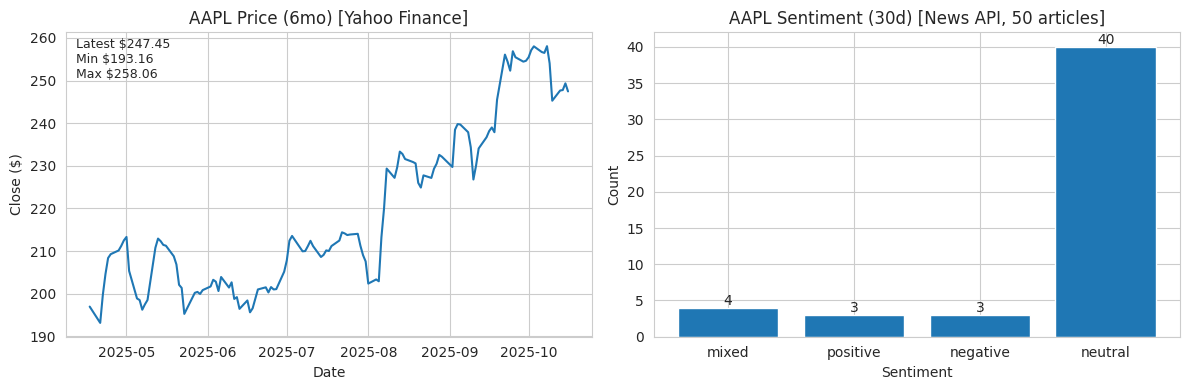

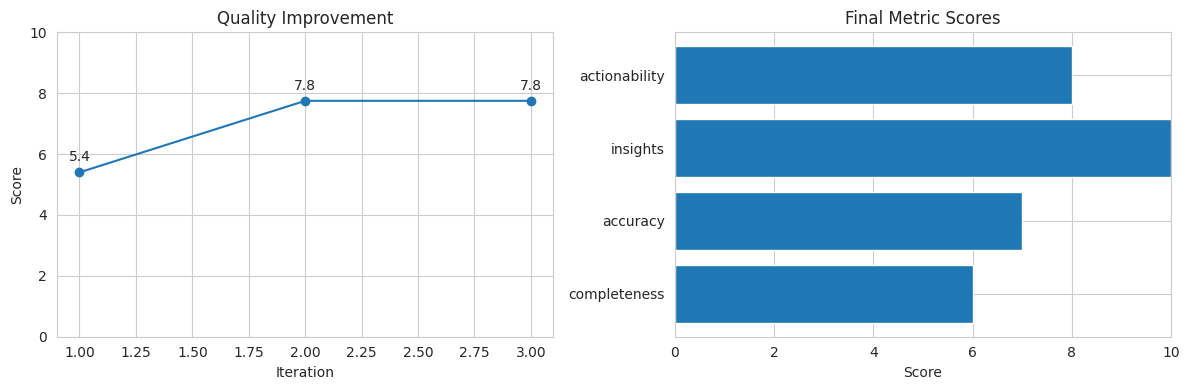

Quality: 5.4 -> 7.8 (+2.3)
1. AAPL 2025-10-16 22:19
2. AAPL 2025-10-15 02:19
3. AAPL 2025-10-15 02:16
4. AAPL 2025-10-15 02:11
5. AAPL 2025-10-15 01:57
6. AAPL 2025-10-15 01:54
7. AAPL 2025-10-15 01:47
8. AAPL 2025-10-15 01:17
9. AAPL 2025-10-15 01:02
10. AAPL 2025-10-15 00:32
11. AAPL 2025-10-15 00:18
12. AAPL 2025-10-10 07:55
13. AAPL 2025-10-09 21:13
14. AAPL 2025-10-09 20:42
15. AAPL 2025-10-09 20:15
16. AAPL 2025-10-09 19:49
17. AAPL 2025-10-09 19:05
18. AAPL 2025-10-09 18:38

Usage: load_and_display_analysis('investment_analysis_AAPL_20251016_221919.json')


In [16]:
# Visualize results
visualize_price_and_sentiment(ticker)
visualize_analysis_progress(analysis_results)

# Display formatted report
load_and_display_analysis()

In [17]:
load_and_display_analysis('investment_analysis_AAPL_20251015_021922.json')


Investment Analysis: AAPL  |  2025-10-15T02:18:05.812097

Executive SummaryY
----------------------------------------------------------------------
Investment Analysis for AAPL
Date: 2025-10-15
Key Findings:
- News: No significant insights extracted
- Quality Score: 7.7/10 (after 3 optimization iterations)
- Leveraged 13 prior analyses for improved insights

Reflection
----------------------------------------------------------------------
1. Completeness: 7/10 - The analysis includes technical analysis, news sentiment
analysis, and starts to explore fundamental analysis, but it doesn't provide a
complete view of the fundamentals. The financial performance, earnings, revenue,
profits, and other key metrics are not mentioned.
2. Accuracy: 8/10 - The information provided appears to be accurate, with
references to recent product releases and industry issues like the chip
shortage. However, without the full text, it's hard to confirm the accuracy of
the entire analysis.
3. Insights Quality

{'symbol': 'AAPL',
 'timestamp': '2025-10-15T02:18:05.812097',
 'components': {'plan': ["1. **Initial Research:** Start by gathering basic information about Apple Inc. (AAPL). This includes the company's history, business model, product lines, and management team.",
   '2. **Data Collection:** Collect the necessary data required for the analysis:',
   "3. **Preliminary Data Analysis:** Analyze the collected data to understand the company's financial health and market position.",
   "4. **In-Depth Analysis:** Conduct a more detailed analysis of the company's performance and prospects.",
   '5. **Quality Checks:** Ensure the analysis is accurate and reliable.',
   '6. **Report Writing:** Write a detailed investment research report on AAPL. The report should include an introduction, key findings, detailed analysis, and conclusion.',
   '7. **Peer Review:** Have the report reviewed by a peer'],
  'data_collection': {'routing': {'Analyze price trends for AAPL': {'agent': 'MarketPro',
     '